<a href="https://colab.research.google.com/github/willowcoleman/hmc-senior-thesis/blob/main/pix2pix_opti_thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
## Import libraries
import tensorflow as tf
import numpy as np
tf.__version__

import time
import datetime
import glob
import imghdr
from pathlib import Path

import os
import pathlib
import cv2
import csv

from matplotlib import pyplot as plt
from IPython import display 
from zipfile import ZipFile
from PIL import Image
from osgeo import gdal, ogr

from scipy.ndimage import gaussian_filter
!pip install sewar
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
from statistics import mean
from scipy.stats import levene 

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


In [2]:
## Load in zipped training data sets 
train_zip = '/content/drive/MyDrive/Colab Notebooks/HMC Thesis/train_128_norm.zip'
test_zip = '/content/drive/MyDrive/Colab Notebooks/HMC Thesis/test_128_norm.zip'

# Extract all zipped files to /Retiled_128 dir in Drive
with ZipFile(train_zip, 'r') as zip_f:
  print('Extracting all TRAINING files now...')
  zip_f.extractall()
  print('Done!')

# Extract all zipped files to /Retiled_256 dir in Drive
with ZipFile(test_zip, 'r') as zip_f:
  print('Extracting all TESTING files now...')
  zip_f.extractall()
  print('Done!')
  

Extracting all TRAINING files now...
Done!
Extracting all TESTING files now...
Done!


In [3]:
path, dirs, files = next(os.walk('/content/test_128_norm/'))
file_count = len(files)
print(file_count)

2595


## Check for and delete any corrupted training images ##


In [4]:
def load(image_file):

  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # (1) a real building facade image
  # (2) an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  lst_img = image[:, w:, :]
  ms_img = image[:, :w, :]

  # Convert both images to float32 tensors
  lst_img = tf.cast(lst_img, tf.float32)
  ms_img = tf.cast(ms_img, tf.float32)

  return ms_img, lst_img

In [13]:
## TEST ## 
data_dir = '/content/test_128_norm/' 
image_extensions = [".jpeg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
del_list = []

for filepath in Path(data_dir).rglob("*"):
  if filepath.suffix.lower() in image_extensions:
    img_type = imghdr.what(filepath)
    if img_type is None:
      print(f"{filepath} is not an image")
      del_list.append(str(filepath))
    if img_type not in img_type_accepted_by_tf:
      print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
      del_list.append(str(filepath))
    if img_type is not None:
      ms_img, lst_img = load(str(filepath))
      if ms_img.shape[1] != 128 or lst_img.shape[1] != 128: 
        print(f"{filepath} is the wrong shape")
        del_list.append(str(filepath))

## Delete any files from del_list (not real images)
for del_file in del_list: 
  if Path(del_file).is_file():
    os.remove(del_file)
    print(os.path.basename(del_file), 'deleted')

## TRAIN ## 
data_dir = '/content/train_128_norm/'
del_list = []

for filepath in Path(data_dir).rglob("*"):
  if filepath.suffix.lower() in image_extensions:
    img_type = imghdr.what(filepath)
    if img_type is None:
      print(f"{filepath} is not an image")
      del_list.append(str(filepath))
    if img_type not in img_type_accepted_by_tf:
      print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
      del_list.append(str(filepath))
    if img_type is not None:
      ms_img, lst_img = load(str(filepath))
      if ms_img.shape[1] != 128 or lst_img.shape[1] != 128: 
        print(f"{filepath} is the wrong shape")
        del_list.append(str(filepath))

## Delete any files from del_list (not real images)
for del_file in del_list: 
  if Path(del_file).is_file():
    os.remove(del_file)
    print(os.path.basename(del_file), 'deleted')


## Normalization ##
Creates a normalization/de-normalization look-up table for each tile 

In [33]:
def load_for_norm(image_file):
  name = str(os.path.basename(image_file)[:-5])

  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # (1) a real building facade image
  # (2) an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  lst_img = image[:, w:, :]
  ms_img = image[:, :w, :]

  # Convert both images to float32 tensors
  lst_img = tf.cast(lst_img, tf.float32)
  ms_img = tf.cast(ms_img, tf.float32)

  return ms_img, lst_img, name

In [34]:
# Extract parameters used for per-tile normalization 
def normalization_table(ms_img, lst_img): 
  ms_min = np.min(ms_img)
  ms_max = np.max(ms_img)
  lst_min = np.min(lst_img)
  lst_max = np.max(lst_img)

  return ms_min, ms_max, lst_min, lst_max

# Iterate through all train/test files to create lookup table 
test_lookup = {}
test_dir = '/content/test_128_norm/' 
for test in Path(test_dir).rglob("*.jpeg"):
  ms_img, lst_img, name = load_for_norm(str(test))
  ms_min, ms_max, lst_min, lst_max = normalization_table(ms_img, lst_img)
  test_lookup[name] = [ms_min, ms_max, lst_min, lst_max]

train_lookup = {}
train_dir = '/content/train_128_norm/'
for train in Path(train_dir).rglob("*.jpeg"):
  ms_img, lst_img, name = load_for_norm(str(train))
  ms_min, ms_max, lst_min, lst_max = normalization_table(ms_img, lst_img)
  train_lookup[name] = [ms_min, ms_max, lst_min, lst_max]

In [35]:
# Write lookup table to csv file saved in Drive
zd_train = zip(*train_lookup.values())
with open('train_lookup.csv', 'w') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(train_lookup.keys())
    writer.writerows(zd_train)

zd_test = zip(*test_lookup.values())
with open('test_lookup.csv', 'w') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(test_lookup.keys())
    writer.writerows(zd_test)

## From pix2pix tutorial

In [36]:
# Apply random jittering and mirroring to preprocess training data set (recommended by pix2pix paper)

BUFFER_SIZE = 400 # Default from pix2pix
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 128x128 in size
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Resize each 128x128 image to 158x158
def resize(ms_img, lst_img, height, width):
  ms_img = tf.image.resize(ms_img, [height, width], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR) 
  lst_img = tf.image.resize(lst_img, [height, width], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return ms_img, lst_img

# Randomly crop image to 128x128
def random_crop(ms_img, lst_img):
  stacked_image = tf.stack([ms_img, lst_img], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# Normalize images from [-1, 1] by tile (will need to be later denormalized by tile using pre-created lookup tables)
def normalize_by_tile(ms_img, lst_img): 
  ms_min = tf.math.reduce_min(ms_img)
  ms_max = tf.math.reduce_max(ms_img)
  ms_img = (2*(ms_img - ms_min)/(ms_max - ms_min)) - 1 

  lst_min = tf.math.reduce_min(lst_img)
  lst_max = tf.math.reduce_max(lst_img)
  lst_img = (2*(lst_img - lst_min)/(lst_max - lst_min)) - 1 

  ms_img = tf.cast(ms_img, tf.float32)
  lst_img = tf.cast(lst_img, tf.float32)

  return ms_img, lst_img

# Denormalize images using pre-created look-up tables (different for training/test)
def denormalize_by_tile(img_min, img_max, norm_img):
    return img_min + (0.5)*(img_max - img_min)*(norm_img + 1)

@tf.function()
def random_jitter(ms_img, lst_img):
  # Resizing to 158x158
  ms_img, lst_img = resize(ms_img, lst_img, 158, 158)

  # Random cropping back to 128x128
  ms_img, lst_img = random_crop(ms_img, lst_img)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    ms_img = tf.image.flip_left_right(ms_img)
    lst_img = tf.image.flip_left_right(lst_img)

  return ms_img, lst_img

train_10_la_summer_2_1
(128, 128, 3)


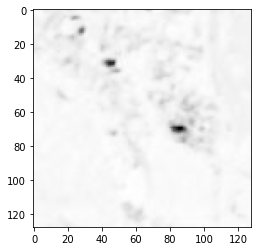

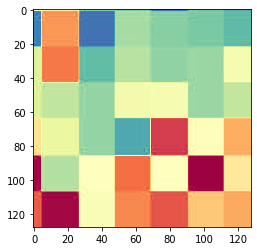

In [37]:
# Test load(image_file) function and plot outputs
ms, lst = load('/content/test_128_norm/test_0_austin_spring_2_1.jpeg')

print(name)
print(ms.shape)

# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(ms[:,:, 1], cmap = 'Greys')
plt.figure()
plt.imshow(lst[:,:,1], cmap = 'Spectral')
plt.show()

## Results of preprocessing (jitter)

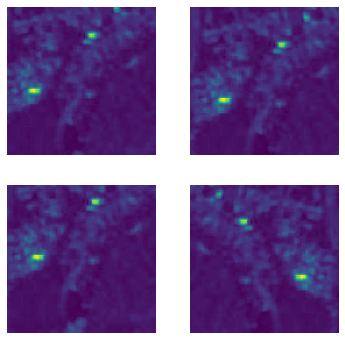

In [38]:
os.chdir('/content/test_128_norm/')
curr_dir = '/content/test_128_norm/'
img_file = 'test_0_austin_spring_2_1.jpeg'

plt.figure(figsize=(6, 6))
for i in range(4):
  ms_img, lst_img = load(img_file)
  ms_img, lst_img = random_jitter(ms_img, lst_img)
  plt.subplot(2,2,i+1)
  plt.imshow(ms_img[:,:,1])
  plt.axis('off')
plt.show()

In [39]:
# Load and preprocess training/test sets 

def load_image_train_jitter(image_file):
  ms_img, lst_img = load(image_file)
  ms_img, lst_img = random_jitter(ms_img, lst_img)
  ms_img, lst_img  = normalize_by_tile(ms_img, lst_img)

  return lst_img, ms_img

def load_image_train(image_file):
  ms_img, lst_img = load(image_file)
  ms_img, lst_img  = normalize_by_tile(ms_img, lst_img)

  return lst_img, ms_img

def load_image_test(image_file):
  ms_img, lst_img = load(image_file)
  ms_img, lst_img  = normalize_by_tile(ms_img, lst_img)

  return lst_img, ms_img

In [40]:
# Build input pipeline (jittered + non-jittered training data)
train_dataset = tf.data.Dataset.list_files('/content/train_128_norm/*.jpeg')
print('# of training images before jitter :', len(train_dataset))
train_dataset_1 = train_dataset.map(load_image_train, 
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(load_image_train_jitter, 
                                         num_parallel_calls = tf.data.AUTOTUNE)
train_dataset = train_dataset_1.concatenate(train_dataset_2)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

print('# of training images after jitter :', len(train_dataset))

test_dataset = tf.data.Dataset.list_files('/content/test_128_norm/*.jpeg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

print('# of test images:', len(test_dataset))

# of training images before jitter : 5923
# of training images after jitter : 11846
# of test images: 2487


## Building out GAN

Input = lst_img

Real = ms_img


In [41]:
# Build generator (modified U-net)

# Downsampler (encoder)
OUTPUT_CHANNELS = 3 
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(lst_img, 0)) ## was originally inp instead of lst_img
print ('down result:', down_result.shape)

# Upsampler (decoder)
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print ('up result:', up_result.shape)

# Generator
def Generator():
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  down_stack = [
    # downsample(32, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(64, 4, apply_batchnorm = False),  # (batch_size, 64, 64, 128)
    downsample(128, 4),  # (batch_size, 32, 32, 256)
    downsample(256, 4),  # (batch_size, 16, 16, 512)
    downsample(256, 4),  # (batch_size, 8, 8, 512)
    downsample(256, 4),  # (batch_size, 4, 4, 512)
    downsample(256, 4),  # (batch_size, 2, 2, 512)
    downsample(256, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(256, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(256, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(256, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(256, 4),  # (batch_size, 16, 16, 1024)
    upsample(128, 4),  # (batch_size, 32, 32, 512)
    upsample(64, 4),  # (batch_size, 64, 64, 256)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# Visualize generator model architecture 
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

down result: (1, 64, 64, 3)
up result: (1, 128, 128, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


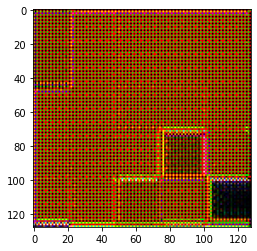

In [42]:
# Test generator
gen_output = generator(lst_img[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])
plt.show()

In [43]:
# Define generator loss (sigmoid cross-entropy loss)
LAMBDA = 100 
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [44]:
# Build discriminator (convolutional PatchGAN classifier)

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[128, 128, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(32, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(64, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(128, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(256, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

# Visualize discriminator model architecture
discriminator = Discriminator()
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

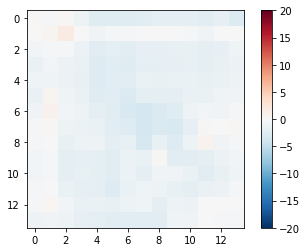

In [45]:
# Test discriminator
disc_out = discriminator([lst_img[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.show()

In [46]:
# Define discriminator loss 
  # Takes in real images and generator images 
  # Calculates sigmoid cross-entropy loss of generated and real images
  
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [47]:
# Define optimizers (different for generator and discriminator b/c networks are trained separately)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Create checkpoint-saver for running long training models
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

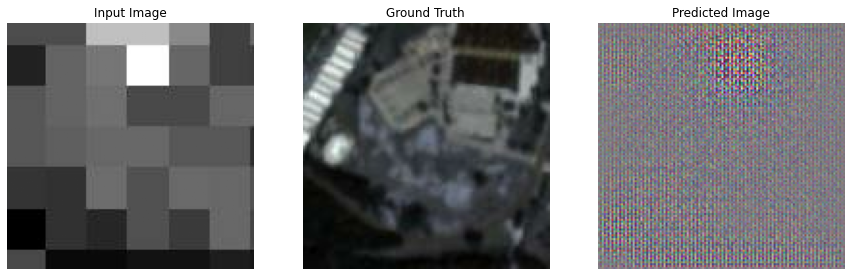

In [48]:
# Plot images during training
def generate_images(model, test_input, tar, plot = True):
  prediction = model(test_input, training=True)

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if plot: 
    plt.figure(figsize=(15, 15))
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

  return prediction[0]

for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [49]:
# pix2pix training 

# Log training metrics (losses) to TensorBoard
# https://www.tensorflow.org/tensorboard/scalars_and_keras 
os.chdir('/content/')
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    # Each example input generates an output 
    gen_output = generator(input_image, training=True)

    # Discriminator receives generated and real image 
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    # Calculate generator and discriminator loss 
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  # Calculate gradients of loss 
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  # Apply gradients of loss to optimizer 
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  # Log losess 
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [50]:
# Training loop 
  # Every 10 steps = print a dot (.)
  # Every 1000 steps = clear display and run generate_iamges to show progress
  # Every 5000 steps = save a checkpoint 
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
      print('checkpoint saved!')

Time taken for 1000 steps: 21.26 sec



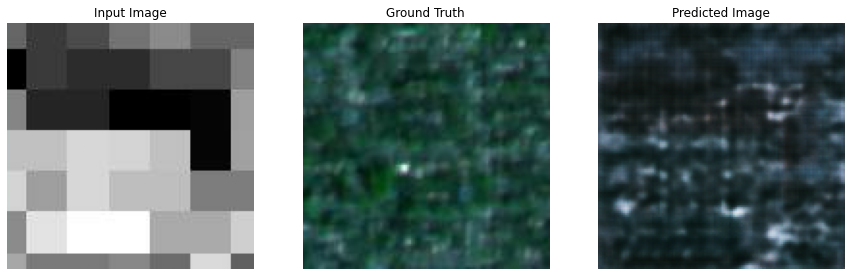

Step: 29k
....................................................................................................checkpoint saved!

Total training time: 700.0625069141388


In [51]:
# Run training loop!! 
import time

start = time.time()
fit(train_dataset, test_dataset, steps=30000)
end = time.time()
print()
print('Total training time:', end - start)

In [52]:
def invisible_ax(ax):
    """
    Removes axes labels and tick marks for simple patch-pair visualizations
    """
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return ax 
    
def plot_side_by_side(ms, lst, pan = None): 
  r = ms[:,:,0]
  g = ms[:,:,1]
  b = ms[:,:,2]
  rgb_img = np.stack((r,g,b)).T
  if pan is not None: 
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    ax1 = invisible_ax(ax1)
    ax2 = invisible_ax(ax2)
    ax3 = invisible_ax(ax3)
    ax1.imshow(rgb_img)
    ax1.set_title('RGB')
    ax2.imshow(lst, cmap='Spectral_r')
    ax2.set_title('LST')
    ax3.imshow(pan, cmap='Spectral_r')
    ax3.set_title('Sharpened LST')
  else: 
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1 = invisible_ax(ax1)
    ax2 = invisible_ax(ax2)
    ax1.imshow(rgb_img)
    ax1.set_title('RGB')
    ax2.imshow(lst[:,:,0], cmap='Spectral_r') 
    ax2.set_title('LST')
  plt.show()

In [53]:
def variance_signficance(ind_dict, ms_flat, gaussian_denorm_flat, plot = False):
  ms_var = [] # store variance of RGB imagery 
  gaussian_var = [] # store variance of avg_gaussian

  # Iterate through unique LST values
  for key in ind_dict: 
    temp_ms = []
    temp_gaussian = []
    inds = ind_dict[key]
    # Iterate through indices with a unique LST value
    for ind in inds: 
      temp_ms.append(ms_flat[ind])
      temp_gaussian.append(gaussian_denorm_flat[ind])
    ms_var.append(np.var(temp_ms))
    gaussian_var.append(np.var(temp_gaussian))

    # Plot distribution of variance of MS and sharpened LST imagery from the same patch-pair
  if plot == True: 
    plt.hist(ms_var, bins = 10, edgecolor = 'black', color = '#43751e')
    plt.title("Variance of MS image" )
    plt.xlabel('Normalized RGB')
    plt.ylabel('Frequency')
    plt.show()

    plt.hist(gaussian_var, bins = 10, edgecolor = 'black', color = '#035a6e')
    plt.title("Variance of Pansharpened Gaussian-Smoothed LST")
    plt.xlabel('Normalized LST')
    plt.ylabel('Frequency')
    plt.show()

  # If p < 0.05, the populations do not have equal variances 
  stat, p = levene(ms_var, gaussian_var)

  return p

In [57]:
# Empty lists for image quality metrics 
rmse_spatial_list = []
rmse_spectral_list = []
ergas_spatial_list = []
ergas_spectral_list = []
sam_list = []

p_list = [] # Keep track if difference in variances is signficant

for lst, ms in test_dataset.take(2000):
  plot = False
  pan = generate_images(generator, lst, ms, plot) # [-1,1]
  pan = pan[:,:,0]
  lst = lst[0,:,:,0]
  ms = ms[0,:,:]

  # Calculate image quality metrics (normalized images)
  if pan.shape == lst.shape: 
    rmse_spectral_list.append(rmse(pan, lst))
    rmse_spatial_list.append(rmse(pan, ms[:,:,0]))
    ergas_spectral_list.append(ergas(pan, lst))
    ergas_spatial_list.append(ergas(pan, ms[:,:,0]))
    sam_list.append(sam(pan, lst))

In [ ]:
# Summary statistics of image quality metrics 
N = len(ergas_spectral_list)
plt.hist(rmse_spectral_list, bins = 20, edgecolor = 'black', color = '#870f25')
plt.title(str(N) + ' pix2pix sharpened test images: RMSE (Spectral Distortion)')
plt.xlabel('RMSE (Spectral)')
plt.ylabel('Frequency')
plt.xlim(0,1.2)
plt.ylim(0,700)
plt.show()

plt.hist(rmse_spatial_list, bins = 20, edgecolor = 'black', color = '#870f25')
plt.title(str(N) + ' pix2pix sharpened test images: RMSE (Spatial Distortion)')
plt.xlabel('RMSE (Spatial)')
plt.ylabel('Frequency')
plt.xlim(0,1.2)
plt.ylim(0,700)
plt.show()

ergas_spectral_list_f = filter(lambda num: num < np.percentile(ergas_spectral_list, 95), ergas_spectral_list)

plt.hist(list(ergas_spectral_list_f), bins = 20, edgecolor = 'black', color = '#035a6e')
plt.title(str(N) + ' pix2pix sharpened test images: ERGAS (Spectral Quality)')
plt.xlabel('ERGAS (Spectral)')
plt.ylabel('Frequency')
plt.xlim(0,100000)
plt.ylim(0,500)
plt.show()

ergas_spatial_list_f = filter(lambda num: num < np.percentile(ergas_spatial_list, 95), ergas_spatial_list)

plt.hist(list(ergas_spatial_list_f), bins = 20, edgecolor = 'black', color = '#035a6e')
plt.title(str(N) + ' pix2pix sharpened test images: ERGAS (Spatial Quality)')
plt.xlabel('ERGAS (Spatial)')
plt.ylabel('Frequency')
plt.xlim(0,100000)
plt.ylim(0,500)
plt.show()

plt.hist(sam_list, bins = 20, edgecolor = 'black', color = '#43751e')
plt.title(str(N) + ' pix2pix sharpened test images: SAM (Spectral Distortion)')
plt.xlabel('SAM (Spectral)')
plt.ylabel('Frequency')
plt.xlim(0,2.5)
plt.ylim(0,1000)
plt.show()

In [ ]:
# Apply trained pix2pix model

for f in os.listdir('/content/test_128_norm/')[20:21]:
  # Load in training image
  print('File name:', f)
  ms, lst = load(os.path.join('/content/test_128_norm', f))

  # Normalize iamges from [-1,1]
  ms_norm, lst_norm = normalize_by_tile(ms, lst)
  ms_norm = ms_norm.numpy().T 

  # Pansharpening 
  pan = generator(lst_norm, training=True)[0]

  # Apply Gaussian blurring to get rid of quilting edge effects
  gaussian = gaussian_filter(pan[0,0,:,:], sigma = 5)
  gaussian = resize(gaussian, (128,128),3)

  plot_side_by_side(ms, lst, pan)
  plot_side_by_side(ms, lst, gaussian)
